In [15]:
import pandas as pd
import numpy as np

In [16]:
iris = pd.read_csv('Iris.csv')
iris.drop(columns=['Id'], inplace=True)

In [17]:
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [18]:

species_mapping = {species: idx for idx, species in enumerate(iris['Species'].unique())}
iris['Species'] = iris['Species'].map(species_mapping)

In [19]:
def entropy(y):
    #entropy of label dist
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

In [20]:
def information_gain(X_col, y, split_threshold):
    #information gain for potential split
    parent_entropy = entropy(y)
    left_indices = X_col <= split_threshold
    right_indices = X_col > split_threshold

    if sum(left_indices) == 0 or sum(right_indices) == 0:
        return 0

    n = len(y)
    n_left, n_right = sum(left_indices), sum(right_indices)
    left_entropy = entropy(y[left_indices])
    right_entropy = entropy(y[right_indices])

    child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
    return parent_entropy - child_entropy

In [21]:
def best_split(X, y):
    best_gain = -1
    best_feature = None
    best_threshold = None

    for col in range(X.shape[1]):
        thresholds = np.unique(X[:, col])
        for threshold in thresholds:
            gain = information_gain(X[:, col], y, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = col
                best_threshold = threshold
    return best_feature, best_threshold

In [22]:
#decision tree structure
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if n_labels == 1 or n_samples == 0 or (self.max_depth and depth >= self.max_depth):
            most_common_label = np.argmax(np.bincount(y))
            return {'label': most_common_label}

        feature, threshold = best_split(X, y)
        if feature is None:
            most_common_label = np.argmax(np.bincount(y))
            return {'label': most_common_label}

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)

        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def predict_sample(self, x, tree):
        if 'label' in tree:
            return tree['label']
        feature = tree['feature']
        threshold = tree['threshold']
        if x[feature] <= threshold:
            return self.predict_sample(x, tree['left'])
        else:
            return self.predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])


In [23]:

from sklearn.model_selection import train_test_split

In [24]:
X = iris.iloc[:, :-1].values  #features
y = iris.iloc[:, -1].values  #labels

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
#train decision tree
tree = DecisionTree(max_depth=3)
tree.tree = tree.fit(X_train, y_train)

In [27]:
#predict
y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.93


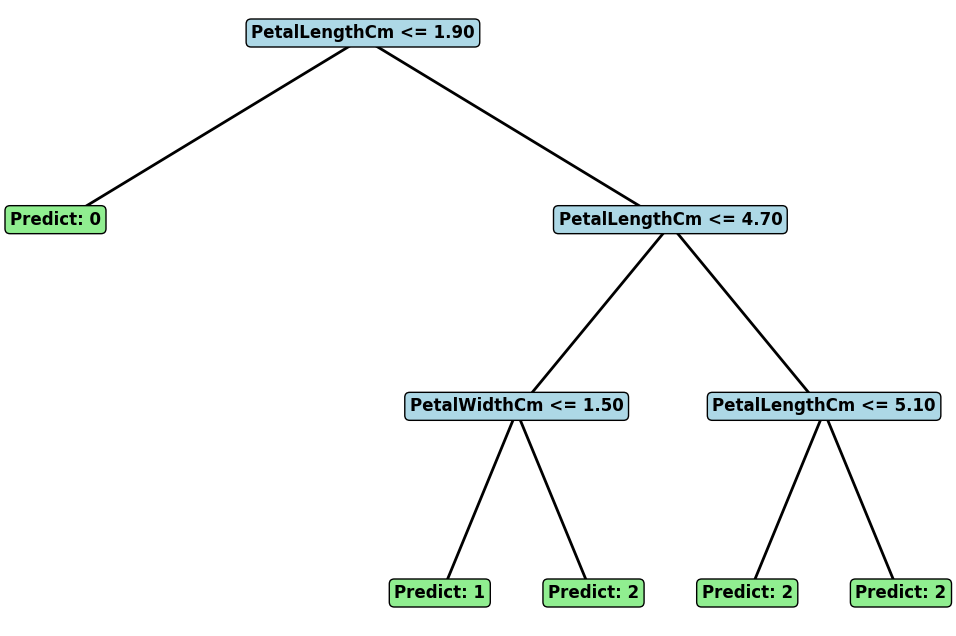

In [28]:
import matplotlib.pyplot as plt

feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

def plot_tree(tree, feature_names, x=0.5, y=1.0, dx=0.1, dy=0.1, ax=None, depth=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')

    if 'label' in tree:
        ax.text(x, y, f"Predict: {tree['label']}", ha='center', fontsize=12, fontweight='bold', 
                bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.3'))
        return

    feature = feature_names[tree['feature']]
    threshold = tree['threshold']
    ax.text(x, y, f"{feature} <= {threshold:.2f}", ha='center', fontsize=12, fontweight='bold',
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

    left_x, right_x = x - dx / (2 ** depth), x + dx / (2 ** depth)

    ax.plot([x, left_x], [y, y - dy], 'k-', lw=2)  # Left branch
    ax.plot([x, right_x], [y, y - dy], 'k-', lw=2)  # Right branch

    plot_tree(tree['left'], feature_names, left_x, y - dy, dx, dy, ax, depth + 1)
    plot_tree(tree['right'], feature_names, right_x, y - dy, dx, dy, ax, depth + 1)

plot_tree(tree.tree, feature_names)

plt.show()
